# End-to-End Data Science Project: E-commerce Customer Lifetime Value

Link to Github Repo:https://github.com/yashica95/end-to-endproject
## Motivation: 
The project's purpose is to apply the knowledge of the data science lifecycle and build an end-to-end machine learning example of working an enterprise-grade data science problem - including problem framing, data extraction and exploration, model building and fine tuning and finally reporting the results and insights drawn from the ML model. 


## Overview: 
This project uses the Brazilian E-Commerce Public Dataset published by Olist on Kaggle to demonstrate the scoping and implementation of a real-world data science project. The dataset's description on Kaggle states:

### Context: 
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. 

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

### Data: 
The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses. 
More information can be found here: https://www.kaggle.com/olistbr/brazilian-ecommerce
![](https://github.com/yashica95/end-to-endproject/blob/main/data/Database%20Diagram.png)

### Goal:

The goal is to propose a supervised model that can predict the customer lifetime value (LTV) based on the purchase history of the customers. By knowing the LTV of the customers, the company can focus on the customers who have higher LTV and therefore have better ROI of marketing budget. The proposed solution will contain a csv of customers and expected LTV of the customers. The primary goal of this work is to build a probabilistic model for forecasting customer lifetime value:

Using the results of this exercise, managers should be able to:

* Distinguish active customers from inactive customers.
* Generate transaction forecasts for individual customers.
* Predict the purchase volume of the entire customer base.


First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed as well as Scikit-Learn ≥0.20.

In [113]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', titlesize=20)  # fontsize of the figure title

plt.style.use('seaborn')


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data Acquisition
The dataset was downloaded directly from Kaggle's site and the zipped files was 128mb in size with files in csv format. There were a total of 9 files containing data about products, customers, orders and sellers. The relationship diagram of the database was provided by Olist [here](https://github.com/yashica95/end-to-endproject/blob/main/data/Database%20Diagram.png). The main files that we are concerned with to predict the customer LTV are :
1. olist_customers_dataset.csv : data about the customers; important to know who is the customer 
2. olist_orders_dataset.csv : data about the orders made on the website; important to know who place the order and buying behaviour
3. olist_order_payments_dataset.csv : data about the payment method of each order
4. olist_order_items_dataset.csv : data about the products present in each order; important to know what was bought in the order placed by the customer

In [2]:
customer = pd.read_csv("../data/olist_customers_dataset.csv")
order = pd.read_csv("../data/olist_orders_dataset.csv")
payment = pd.read_csv("../data/olist_order_payments_dataset.csv")
order_item = pd.read_csv("../data/olist_order_items_dataset.csv")

In [3]:
# looking at each dataset 
customer.head(2)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP

This dataset contains data about the customer and ther location. The customer_id is unique for each order places i.e. for each order placed by the customer, the system creates a unique customer_id that can be used to link to the order dataset. To identify unique customers, we should use customer_unique_id and not customer_id

In [4]:
#looking at order dataset 
order.head(2)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00

This dataset contains the information about the order - who placed the order, when was it placed and when was it delivered. The order_id can be used to link to the order item dataset

In [5]:
#looking at order items dataset
order_item.head(2)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93

This dataset contains the information of products purchased in each order placed by a customers, inluding information like freight value, seller information and most importantly - price of each item

In [6]:
#looking at the payment dataset
payment.head(2)

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39

Payment datasets contains data about payment methods used by the customers ( they can be multiple denoted by payment_sequential) and the total payment value. This dataset might be useful to find the total amount of the order placed by the customers

In [7]:
#combine all the data in one dataframe so it's easier to visualise data

#combining customer and order dataset on customer_id
df = pd.merge(order,customer, on = "customer_id" , how = "left") 

#combining order item dataset on order_id
df = pd.merge(order_item, df , on = "order_id" , how = "left" )

#combining payment dataset on order_id
df = pd.merge(df, payment, on = "order_id", how = "left")

In [8]:
#looking at the combined dataset df 
df.head(5)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  \
0  2017-09-19 09:45:35   58.90          13.29   
1  2017-05-03 11:05:13  239.90          19.93   
2  2018-01-18 14:48:30  199.00          17.87   
3  2018-08-15 10:10:18   12.99          12.79   
4  2017-02-13 13:57:51  199.90          18.14   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    delivered      2018-01-14 14:33:31   
3  d4eb9395c8c0431ee92fce09860c5a06    delivered      2018-08-08 10:00:35   
4  58dbd0b2d70206bf40e62cd34e84d795    delivered      2017-02-04 13:57:51   

   ... order_delivered_customer_date order_estimated_delivery_date  \
0  ...           2017-09-20 23:43:48           2017-09-29 00:00:00   
1  ...           2017-05-12 16:04:24           2017-05-15 00:00:00   
2  ...           2018-01-22 13:19:16           2018-02-05 00:00:00   
3  ...           2018-08-14 13:32:39           2018-08-20 00:00:00   
4  ...           2017-03-01 16:42:31           2017-03-17 00:00:00   

                 customer_unique_id customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                    28013   
1  eb28e67c4c0b83846050ddfb8a35d051                    15775   
2  3818d81c6709e39d06b2738a8d3a2474                    35661   
3  af861d436cfc08b2c2ddefd0ba074622                    12952   
4  64b576fb70d441e8f1b2d7d446e483c5                    13226   

           customer_city  customer_state payment_sequential payment_type  \
0  campos dos goytacazes              RJ                1.0  credit_card   
1        santa fe do sul              SP                1.0  credit_card   
2          para de minas              MG                1.0  credit_card   
3                atibaia              SP                1.0  credit_card   
4        varzea paulista              SP                1.0  credit_card   

   payment_installments payment_value  
0                   2.0         72.19  
1                   3.0        259.83  
2                   5.0        216.87  
3                   2.0         25.78  
4                   3.0        218.04  

[5 rows x 22 columns]

In [9]:
#quick look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117604 entries, 0 to 117603
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117604 non-null  object 
 1   order_item_id                  117604 non-null  int64  
 2   product_id                     117604 non-null  object 
 3   seller_id                      117604 non-null  object 
 4   shipping_limit_date            117604 non-null  object 
 5   price                          117604 non-null  float64
 6   freight_value                  117604 non-null  float64
 7   customer_id                    117604 non-null  object 
 8   order_status                   117604 non-null  object 
 9   order_purchase_timestamp       117604 non-null  object 
 10  order_approved_at              117589 non-null  object 
 11  order_delivered_carrier_date   116359 non-null  object 
 12  order_delivered_customer_date 

In [10]:
#Understanding the distribution of the data
df.describe()

order_item_id          price  freight_value  customer_zip_code_prefix  \
count  117604.000000  117604.000000  117604.000000             117604.000000   
mean        1.195920     120.822849      20.045551              35051.271385   
std         0.697721     184.477367      15.861351              29820.387420   
min         1.000000       0.850000       0.000000               1003.000000   
25%         1.000000      39.900000      13.080000              11310.000000   
50%         1.000000      74.900000      16.290000              24315.000000   
75%         1.000000     134.900000      21.190000              58600.000000   
max        21.000000    6735.000000     409.680000              99990.000000   

       payment_sequential  payment_installments  payment_value  
count       117601.000000         117601.000000  117601.000000  
mean             1.093528              2.939482     172.686752  
std              0.726692              2.774223     267.592290  
min              1.000000              0.000000       0.000000  
25%              1.000000              1.000000      60.870000  
50%              1.000000              2.000000     108.210000  
75%              1.000000              4.000000     189.260000  
max             29.000000             24.000000   13664.080000

So we have ~117k rows in the dataset and something interesting we can see is that the payment_value has a max value of 13,664 which seems quite high compared to the 75 percentile. 

## Pandas Profiler

In [26]:
#installing pandas profiler 
!pip install pandas-profiling

#running pandas profiler to understand the distribution, missing data and correlation between the variables
import pandas_profiling
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="plots/output.html")

In [25]:
profile

From the pandas profiling report we have the following information about the dataset:
1. There are lot of null values in order_approved_at, order_delivered_carrier_date,order_deliver_customer_date
2. There are 3 null values in each of payment_sequential, payment_type, payment_installments, payment_value
3. The order dataset also contains order that were cancelled. We might want to exclude these orders from our analysis of customer lifetime value as these orders did not contribute to the total amount spent by the customer in the past 
4. Interestingly, the product's price is highly correlated to the freight value 

Since we have information about when the order was placed, we can ignore the other columns such as order_approved_at, order_delivered_carrier_date,order_deliver_customer_date since they have missing values 

In [11]:
df = df.drop(columns = ["order_approved_at", "order_delivered_carrier_date","order_delivered_customer_date"])

In [12]:
#understand the values in order status 
df.order_status.value_counts()

delivered      115038
shipped          1244
canceled          566
processing        375
invoiced          371
unavailable         7
approved            3
Name: order_status, dtype: int64

In [13]:
#removing the orders that are unavailable or are canceled 
df = df[(df["order_status"]!="canceled") & (df["order_status"]!="unavailable") ]

In [14]:
df.shape

(117031, 19)

## Exploratory Data Analysis

Saving figure attribute_histograms


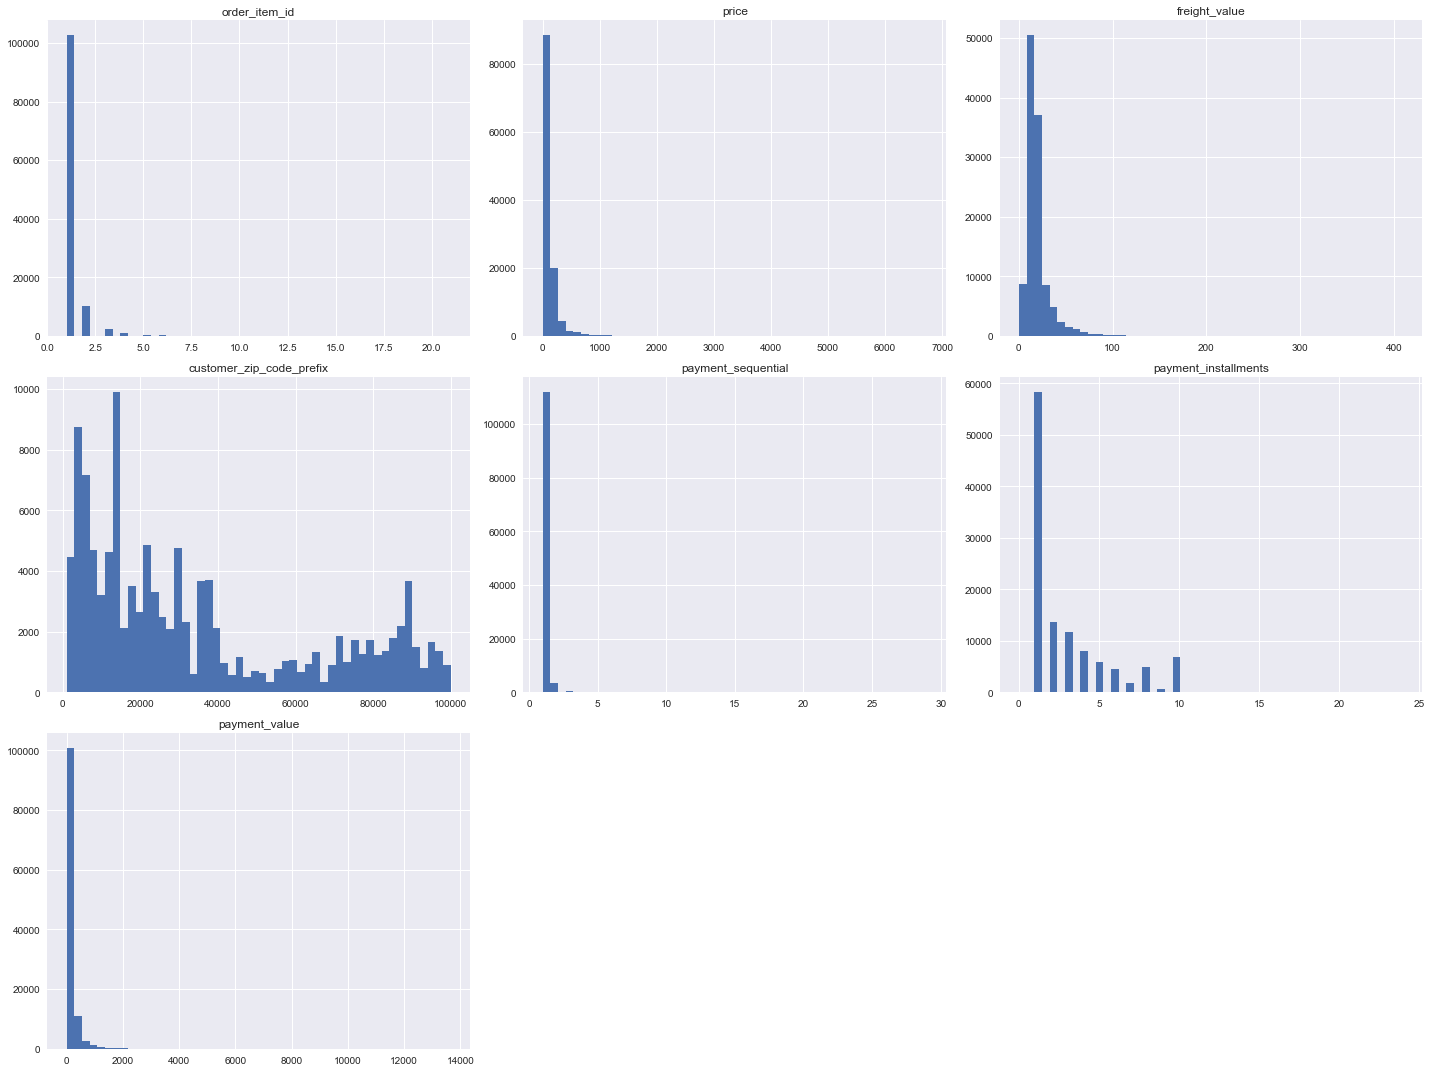

In [55]:
#Plotting the distribution of each attribute that isn't object type 
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histograms")
plt.show()

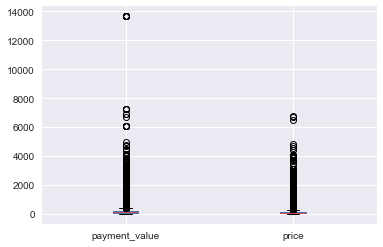

In [54]:
%matplotlib inline
df[["payment_value", "price"]].boxplot()
#save_fig("attribute_boxplots")
plt.show()

In [28]:
#converting columns with dates as datetime types
df[["shipping_limit_date", "order_purchase_timestamp", "order_estimated_delivery_date"]] = df[["shipping_limit_date", "order_purchase_timestamp", "order_estimated_delivery_date"]].apply(pd.to_datetime)

#get the year, month and day of the order 
df["order_month"] = df["order_purchase_timestamp"].dt.month
df["order_year"] = df["order_purchase_timestamp"].dt.year
df["order_day"] = df["order_purchase_timestamp"].dt.day

In [29]:
df.head(2)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   

  shipping_limit_date  price  freight_value                       customer_id  \
0 2017-09-19 09:45:35   58.9          13.29  3ce436f183e68e07877b285a838db11a   
1 2017-05-03 11:05:13  239.9          19.93  f6dd3ec061db4e3987629fe6b26e5cce   

  order_status order_purchase_timestamp  ... customer_zip_code_prefix  \
0    delivered      2017-09-13 08:59:02  ...                    28013   
1    delivered      2017-04-26 10:53:06  ...                    15775   

           customer_city  customer_state payment_sequential payment_type  \
0  campos dos goytacazes              RJ                1.0  credit_card   
1        santa fe do sul              SP                1.0  credit_card   

   payment_installments payment_value  order_month  order_year  order_day  
0                   2.0         72.19            9        2017         13  
1                   3.0        259.83            4        2017         26  

[2 rows x 22 columns]

Text(0.5, 1.0, 'Total Sales')

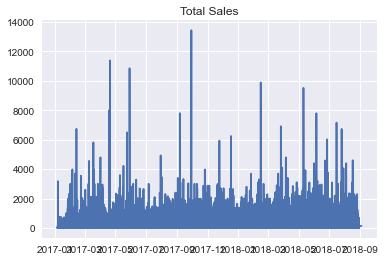

In [92]:
#Calculating the total sum of revenue on each data 
timestamp_revenue = df.groupby(by="order_purchase_timestamp")['price'].sum().reset_index()
timestamp_revenue.set_index("order_purchase_timestamp", inplace=True)
plt.plot(timestamp_revenue)
plt.title("Total Sales")

We can see that the data contains all the order placed from 2016 to 2018 and high peaks/ high sales volume is visible on some days during the given duration of sales data. For 2016, we only have data for only 3 months, we might want to exclude it from the data since from the graph we can see that the transaction volume was quite low for this period

In [41]:
df = df[df["order_year"]>2016]

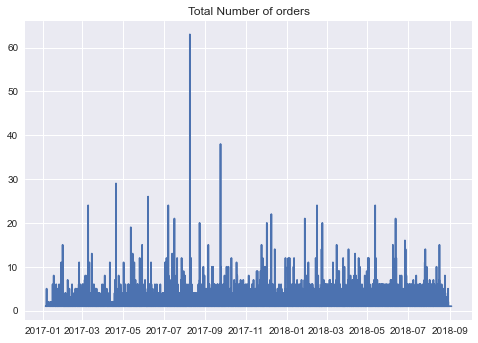

In [43]:
#visualizing the number of orders placed 
timestamp_order_count = df.groupby(by="order_purchase_timestamp")['order_id'].count().reset_index()
timestamp_order_count.set_index("order_purchase_timestamp", inplace=True)
plt.plot(timestamp_order_count)
plt.title("Total Number of orders");

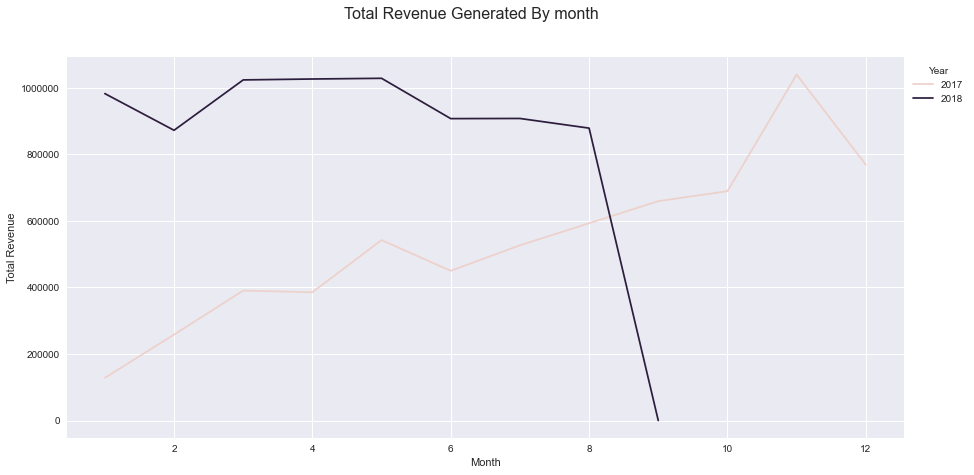

In [119]:
#calculating the total revenue by year and month 

total_revenue = df.groupby(by=['order_year', 'order_month'])['price'].sum().reset_index()

# visualizing it with seaborn
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(x="order_month", y="price", hue="order_year", ax=ax, data=total_revenue)
fig.suptitle('Total Revenue Generated By month', fontsize=16)
ax.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel='Month') 
ax.set(ylabel='Total Revenue')
plt.ticklabel_format(style='plain', axis='y')
plt.show;

From the above graph we can see that there was a growth in total revenue since Jan 2017. The sharp decrease in revenue in 2018 after Aug is because the data is only available upto Aug 2018. 

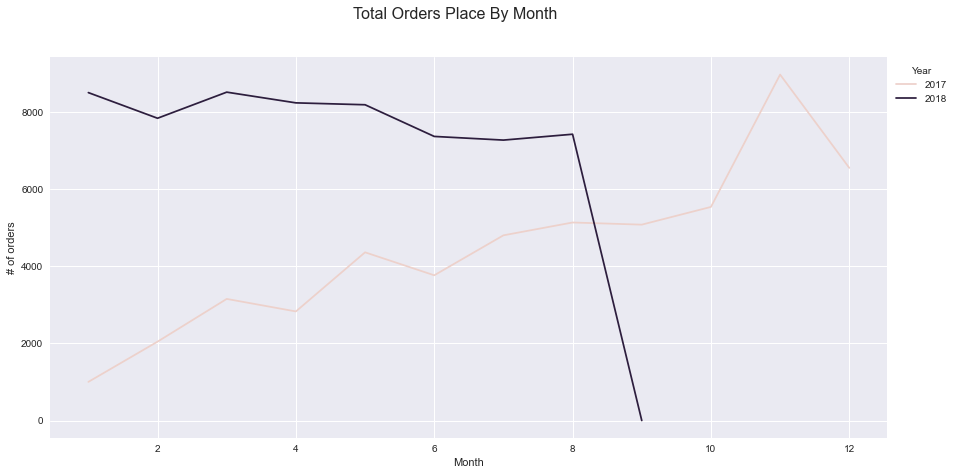

In [123]:
#similarly find the trend in the number of orders placed 

total_orders_count = df.groupby(by=['order_year', 'order_month'])['order_id'].count().reset_index()

# visualizing it with seaborn
fig, ax = plt.subplots(figsize=(15, 7))

sns.lineplot(x="order_month", y="order_id", hue="order_year", ax=ax, data=total_orders_count)
fig.suptitle('Total Orders Place By Month', fontsize=16)
ax.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
ax.set(xlabel='Month') 
ax.set(ylabel='# of orders') 
plt.show;

The graph follows a similar trend as the total revenue generated. It seems like Nov 2017 had the biggest sale day where the number of orders place and revenue generated was the highest

In [191]:
#Creating a data of each order placed and dropping the columns that are not relevant to 
#understand customers purchase behaviours
order_total = df.groupby(by=["order_id","order_purchase_timestamp","customer_unique_id","customer_state"])['price'].sum().reset_index()
order_total.columns = ["OrderID","OrderTimestamp", "CustomerID", "CustomerState", "Total_Spent"]
order_total.head(2)

OrderID      OrderTimestamp  \
0  00010242fe8c5a6d1ba2dd792cb16214 2017-09-13 08:59:02   
1  00018f77f2f0320c557190d7a144bdd3 2017-04-26 10:53:06   

                         CustomerID CustomerState  Total_Spent  
0  871766c5855e863f6eccc05f988b23cb            RJ         58.9  
1  eb28e67c4c0b83846050ddfb8a35d051            SP        239.9

In [212]:
#last transaction date in the whole dataset
finalDate = df['order_purchase_timestamp'].max()

final_df = order_total.groupby(by=["CustomerID"]).agg({'OrderTimestamp': lambda date: (date.max() - date.min()).days,
                                        'OrderID': lambda order_id: order_id.count(),
                                        'Total_Spent': lambda price: price.sum()})
final_df.columns = ["DaysFromFirst&LastOrder","TotalOrders", "TotalSpent"]
final_df.head(5)

DaysFromFirst&LastOrder  TotalOrders  \
CustomerID                                                               
0000366f3b9a7992bf8c76cfdf3221e2                        0            1   
0000b849f77a49e4a4ce2b2a4ca5be3f                        0            1   
0000f46a3911fa3c0805444483337064                        0            1   
0000f6ccb0745a6a4b88665a16c9f078                        0            1   
0004aac84e0df4da2b147fca70cf8255                        0            1   

                                  TotalSpent  
CustomerID                                    
0000366f3b9a7992bf8c76cfdf3221e2      129.90  
0000b849f77a49e4a4ce2b2a4ca5be3f       18.90  
0000f46a3911fa3c0805444483337064       69.00  
0000f6ccb0745a6a4b88665a16c9f078       25.99  
0004aac84e0df4da2b147fca70cf8255      180.00

Now we have a complete data of the customer - 
1. DaysFromFirst&LastOrder : the number of time periods between a customer’s first and last (latest) transactions 
2. TotalOrders: Total number of orders placed by the customer 
3. TotalSpent: Total revenue generated by the customer 

Using this information, we can easily see the trend in the customer purchase bheviour and the distribution of the customers 

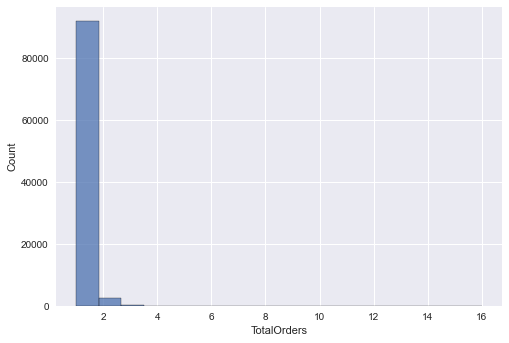

In [232]:
#visualizing the distribution of total orders 
sns.histplot(data=final_df, x="TotalOrders");

We can see that most of the customers have places order only 1 time during the given transaction lifetime i.e. they are not repeat customers. We can see from the customer purchase frequency table that more than 85% of the customers haven't been repeat customers i.e. they have made only 1 purchase in from 2017-2018. It would be more interesting to see which customers order once, low and highly frequently 

Since Lifetime value depends largely on the the frequency of purchase, it would be interesting to know which customer falls in the low, medium & high frequency zones so the marketing team could focus on loyal customers and retain them. 

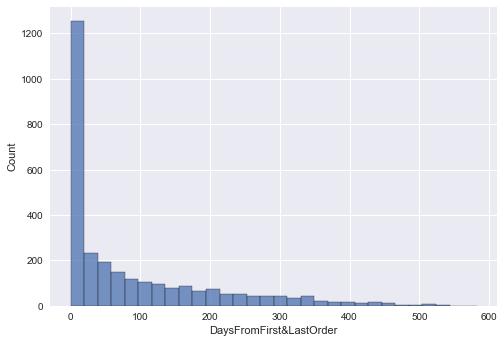

In [241]:
#Visualizing the distribution of number of days from first and last order for repeat customers 
sns.histplot(data=final_df[final_df['TotalOrders']>1], x="DaysFromFirst&LastOrder");

In [245]:
final_df[final_df['TotalOrders']>1]['DaysFromFirst&LastOrder'].describe()

count    2875.000000
mean       86.438609
std       113.563280
min         0.000000
25%         0.000000
50%        34.000000
75%       139.000000
max       582.000000
Name: DaysFromFirst&LastOrder, dtype: float64

Interestingly, some customers have made purchases on the same day of their first transaction. On average, a customer lifetime lasts about ~3 months i.e the days between their first and last purchase date. But there are some outliers in the dataset where the customer has continued to stay with the company for more than 4 months. 

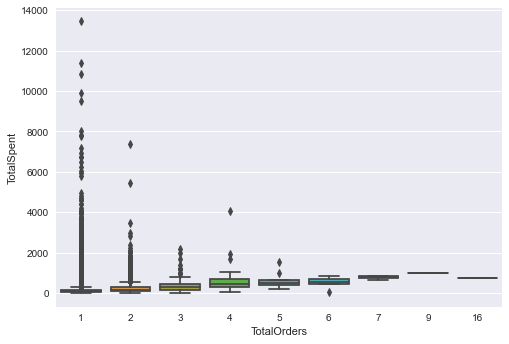

In [248]:
sns.boxplot(data=final_df, y="TotalSpent", x="TotalOrders");

There are definitely outliers present in the total revenue generated per customer, especially in those who only placed an order once or twice. We need to remove these outliers to make sure our model generalizes and not fit on the ourliers

## The RFM Model in Lifetimes: Recency, Frequency, and Monetary Value

The RFM concept rests on the axiom that customers who have placed an order more recently, have purchased more frequently, and tend to spend more on their transactions are likely to be returning customers as well as the most valuable customers. 

Definitions: 
1. Recency: the number of time periods between a customer’s first and last (latest) transactions
2. Frequency: the number of time periods, after the initial purchase, when the customer buys again
3. Monetary Value: the average value of the customer’s transactions (revenues or profit per transaction)
4. Customer age T: the number of time periods since the customer’s first purchase

Source (https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0)

In [249]:
final_df

DaysFromFirst&LastOrder  TotalOrders  \
CustomerID                                                               
0000366f3b9a7992bf8c76cfdf3221e2                        0            1   
0000b849f77a49e4a4ce2b2a4ca5be3f                        0            1   
0000f46a3911fa3c0805444483337064                        0            1   
0000f6ccb0745a6a4b88665a16c9f078                        0            1   
0004aac84e0df4da2b147fca70cf8255                        0            1   
...                                                   ...          ...   
fffcf5a5ff07b0908bd4e2dbc735a684                        0            1   
fffea47cd6d3cc0a88bd621562a9d061                        0            1   
ffff371b4d645b6ecea244b27531430a                        0            1   
ffff5962728ec6157033ef9805bacc48                        0            1   
ffffd2657e2aad2907e67c3e9daecbeb                        0            1   

                                  TotalSpent  
CustomerID                                    
0000366f3b9a7992bf8c76cfdf3221e2      129.90  
0000b849f77a49e4a4ce2b2a4ca5be3f       18.90  
0000f46a3911fa3c0805444483337064       69.00  
0000f6ccb0745a6a4b88665a16c9f078       25.99  
0004aac84e0df4da2b147fca70cf8255      180.00  
...                                      ...  
fffcf5a5ff07b0908bd4e2dbc735a684     1570.00  
fffea47cd6d3cc0a88bd621562a9d061       64.89  
ffff371b4d645b6ecea244b27531430a       89.90  
ffff5962728ec6157033ef9805bacc48      115.00  
ffffd2657e2aad2907e67c3e9daecbeb       56.99  

[94703 rows x 3 columns]

## Creating Test Dataset

Timestamp('2018-09-03 09:06:57')

In [56]:
# to make this notebook's output identical at every run
np.random.seed(42)

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(df, 0.2)
len(train_set)